(2229021이선우과제풀이영상)[https://youtu.be/hdOyGnORZpU]

# 1. Multinomial regression with Python


## 1.1 Revisit logistic regression

## Example 1.1.1: (Heart attack patients)


Suppose that we are working with some doctors on heart attack patients. The dependent variable is whether the patient has had a second heart attack ($Y$)within 1 year (yes = 1). We have two independent variables, one is whether the patient completed a treatment consistent of anger control practices ($x_1$) (yes=1). The other is a score on a trait anxiety scale ($x_2$) (a higher score means more anxious). You want to model

$Y\sim {\rm Ber}(p_i)$

where $p_i=\sigma(x_iW+b)$ with $W=
\left(\begin{matrix}
W_1\\
W_2
\end{matrix}\right).
$

Answer the following problems:

1. Transform `Y` into `T` with one-hot encoding.

2. Build the model which best describe the heart attack mechanism. You may want to standardize the explanatory variables before define the model.

3. In the model, make the probability function `Q`, then train the logistic model.

4. Calculate the train accuracy of the model.

<img src="https://drive.google.com/uc?id=1BJMmWmeDUJFXis6nc7X7Sd6o832B1_OC" height="600" width="400">

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
data = np.array([[1,1,70], [1,1,80], [1,1,50],[1,0,60], [1,0,40], [1, 0, 65], [1,0,75], [1,0,80], [1,0,70], [1,0,60], [0,1,65], [0,1,50], [0,1,45], [0,1,35], [0,1,40], [0,1,50], [0,0,55], [0,0,45], [0,0,50], [0,0,60]], dtype=np.float32)
data

array([[ 1.,  1., 70.],
       [ 1.,  1., 80.],
       [ 1.,  1., 50.],
       [ 1.,  0., 60.],
       [ 1.,  0., 40.],
       [ 1.,  0., 65.],
       [ 1.,  0., 75.],
       [ 1.,  0., 80.],
       [ 1.,  0., 70.],
       [ 1.,  0., 60.],
       [ 0.,  1., 65.],
       [ 0.,  1., 50.],
       [ 0.,  1., 45.],
       [ 0.,  1., 35.],
       [ 0.,  1., 40.],
       [ 0.,  1., 50.],
       [ 0.,  0., 55.],
       [ 0.,  0., 45.],
       [ 0.,  0., 50.],
       [ 0.,  0., 60.]], dtype=float32)

#### Transformation of `Y` of shape `[n,1]` into one-hot encoding `T` of shape `[n,2]`.

In [ ]:
Y = torch.tensor(data[:, 0], dtype=torch.int64)
Y

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
T = torch.nn.functional.one_hot(Y, num_classes=2)
T = T.to(torch.float32)
T

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

#### Standardization of `X` of shape `[n,2]` into `XX` of shape `[n,2]`

In [ ]:
X = torch.tensor(data[:, 1:], dtype=torch.float32)#[n,2]
X_mean = torch.mean(X, axis=0)
X_std = torch.std(X, axis=0)
XX = (X-X_mean) / X_std

#### Create the trainloader with `T` and `XX`. Note that, while we use batch learning, we use `batch_size=20`.

Now, we train the model with `T` and `XX` but not `Y`.

In [ ]:
model = torch.nn.Linear(2,2, bias=True) # W: [2, 2], Y=X@W
def forward(xx): #z=forward(xx)
  return torch.exp(model(xx))
def loss_ftn(T, qhat):
  temp = - torch.mean(torch.sum(T * torch.log(qhat), axis=1))
  return temp

optimizer = torch.optim.SGD(model.parameters(), lr= 0.1)

history=[]
epochs = 1000

for epoch in range(epochs):
    zhat = forward(XX)
    qhat = zhat/torch.sum(zhat, axis=1).reshape([-1,1])
    #qhat: [n,2]
    loss = loss_ftn(T, qhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    history.append(loss.item())

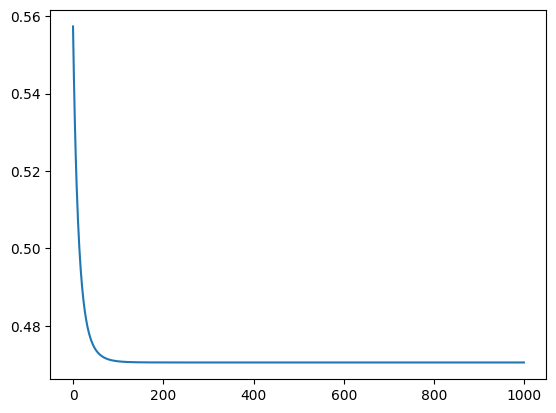

In [ ]:

plt.plot(history)

Now, check the accuracy of the model using `phat=model(XX)` of shape `[n,1]`and `Y` of shape `[n,1]`.

In [ ]:
Zhat = forward(XX)
Qhat = Zhat/torch.sum(Zhat, axis=1).reshape([-1,1])
print(Qhat)

Yhat = torch.argmax(Qhat, axis=1)
Y = torch.argmax(T, axis=1)

torch.mean((Y == Yhat)*1.0)

tensor([[0.2798, 0.7202],
        [0.1056, 0.8944],
        [0.8077, 0.1923],
        [0.3145, 0.6855],
        [0.8323, 0.1677],
        [0.2019, 0.7981],
        [0.0714, 0.9286],
        [0.0407, 0.9593],
        [0.1224, 0.8776],
        [0.3145, 0.6855],
        [0.4133, 0.5867],
        [0.8077, 0.1923],
        [0.8840, 0.1160],
        [0.9616, 0.0384],
        [0.9325, 0.0675],
        [0.8077, 0.1923],
        [0.4541, 0.5459],
        [0.7323, 0.2677],
        [0.6014, 0.3986],
        [0.3145, 0.6855]], grad_fn=<DivBackward0>)


tensor(0.7500)

In [ ]:
def accuracy_ftn(phat, t):
  yhat = (phat>0.5).to(torch.float32)
  y = torch.argmax(t, axis=1).to(torch.float32)
  accuracy = torch.mean((y.reshape([-1,1])==yhat).to(torch.float32))
  return accuracy


In [ ]:
phat = model(XX)
accuracy = accuracy_ftn(phat, T)
accuracy

tensor(0.6000)

In [ ]:
T

tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [ ]:
XX

tensor([[ 1.0775,  0.9498],
        [ 1.0775,  1.6948],
        [ 1.0775, -0.5401],
        [-0.8816,  0.2049],
        [-0.8816, -1.2850],
        [-0.8816,  0.5773],
        [-0.8816,  1.3223],
        [-0.8816,  1.6948],
        [-0.8816,  0.9498],
        [-0.8816,  0.2049],
        [ 1.0775,  0.5773],
        [ 1.0775, -0.5401],
        [ 1.0775, -0.9126],
        [ 1.0775, -1.6575],
        [ 1.0775, -1.2850],
        [ 1.0775, -0.5401],
        [-0.8816, -0.1676],
        [-0.8816, -0.9126],
        [-0.8816, -0.5401],
        [-0.8816,  0.2049]])

## 1.2 Modification of the logistic regression based on the multinomial logistic regression method

## Example 1.2.1: (Revisit heart attack patients)

Now, we do other way of logistic regression.

Here,
with the following parameters
```
weight0: [3,1]
weight1: [3,1]
```
we design
```
p0_hat = torch.exp( XX @ weight0 )
p1_hat = torch.exp( XX @ weight1 )
```
This model is equivalent with
```
p_hat = torch.exp( XX @ weight )
```
with the following parameters
```
weight1: [2,2]
```

Of course, theses are not the legitimate probabilities, and should be normalized.


In [ ]:
torch.std(XX, axis=0)

tensor([1., 1.])

#### Standardization of `X` of shape `[n,2]` into `XX` of shape `[n,2]` and add intercetption term so that `XX` becomes the shape of `[n,3]`

In [ ]:


n=len(X)
ones =torch.ones([n,1])
XX = torch.concatenate([ones, XX], axis=1)
XX.shape

torch.Size([20, 3])

In [ ]:
XX = XX[:, 1:]
XX

tensor([[ 1.0775,  0.9498],
        [ 1.0775,  1.6948],
        [ 1.0775, -0.5401],
        [-0.8816,  0.2049],
        [-0.8816, -1.2850],
        [-0.8816,  0.5773],
        [-0.8816,  1.3223],
        [-0.8816,  1.6948],
        [-0.8816,  0.9498],
        [-0.8816,  0.2049],
        [ 1.0775,  0.5773],
        [ 1.0775, -0.5401],
        [ 1.0775, -0.9126],
        [ 1.0775, -1.6575],
        [ 1.0775, -1.2850],
        [ 1.0775, -0.5401],
        [-0.8816, -0.1676],
        [-0.8816, -0.9126],
        [-0.8816, -0.5401],
        [-0.8816,  0.2049]])

#### Create the trainloader with `T` and `XX`. Note that, while we use batch learning, we use `batch_size=20`.

In [ ]:
dataset = TensorDataset(T,XX)
trainloader = DataLoader(dataset=dataset, batch_size=20, shuffle=True) # We set batch_size = 20 on purpose. Otherwise, train is not working very well.


### Now, we define the model and train.

In [ ]:
class myclass(torch.nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.linear = torch.nn.Linear( in_units, units, bias=False) # X@W, W:[in_units, units]=[3,2]

    def forward(self, X):
        Z = self.linear(X) #X: [n,3]  # Z: [n,2]
        temp = torch.exp(Z)
        Q = temp / torch.sum(temp, axis=1).reshape(-1, 1)
        return Q

reg_ftn = myclass(2,2) # Important

def likelihood_function(tt, qq):
  # tt: one-hot encoding of y, shape: [n,2]
  # phat: probability of shape: [n,2]
  temp = -torch.mean (torch.sum(tt * torch.log(qq), axis=1))
  return temp

optimizer = torch.optim.SGD(reg_ftn.parameters(), lr= 0.1)

In [ ]:
XX.shape

torch.Size([20, 2])

In [ ]:
history=[]
epochs = 1000
n=len(XX)
for i in range(epochs):
  epoch_loss = 0.0
  for tt, xx in trainloader:
    qhat = reg_ftn(xx)
    loss = likelihood_function(tt, qhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    eopch_loss = epoch_loss + loss.item()*len(tt)
  history.append(eopch_loss)

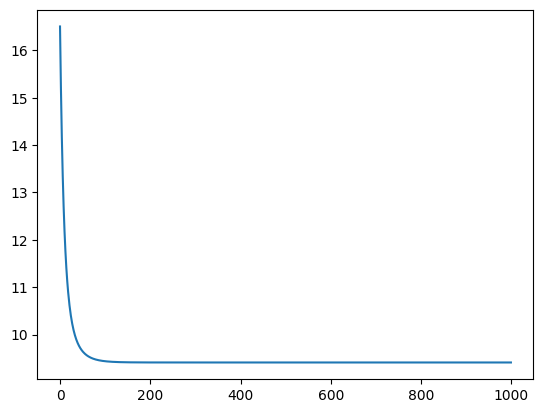

In [ ]:
plt.plot(history)

Now, check the accuracy again.

Now, check the accuracy of the model using `phat=model(XX)` of shape `[n,2]`and `Y` of shape `[n,1]`.

In [ ]:
def accuracy_ftn(qhat, t):
  yhat = torch.argmax(qhat, axis=1).to(torch.float32)
  y = torch.argmax(t, axis=1).to(torch.float32)
  accuracy = torch.mean((y==yhat).to(torch.float32))
  return accuracy


In [ ]:
Qhat = reg_ftn(XX)
accuracy = accuracy_ftn(Qhat, T)
accuracy

tensor(0.7500)

Now, we want to use `torch.nn.Linear` with `bias=False`.
Here,
with the following parameters
```
weight0: [3,1]
weight1: [3,1]
```
we design
```
p0_hat = torch.exp( XX @ weight0)
p1_hat = torch.exp( XX @ weight1)
```
This model is equivalent with
```
p_hat = torch.exp( XX @ weight)
```
with the following parameters
```
weight: [3,2]
```

#### Transformation of `Y` of shape `[n,1]` into one-hot encoding `T` of shape `[n,2]`.

In [ ]:
Y = torch.tensor(data[:, 0], dtype=torch.int64)
T = torch.nn.functional.one_hot(Y, num_classes=2)
T = T.to(torch.float32)

#### Standardization of `X` of shape `[n,2]` into `XX` of shape `[n,2]`

In [ ]:
X = torch.tensor(data[:, 1:], dtype=torch.float32)
X_mean = torch.mean(X, axis=0)
X_std = torch.std(X, axis=0)
XX = (X-X_mean) / X_std

XX: [n,2]

#### Create the trainloader with `T` and `XX`. Note that, while we use batch learning, we use `batch_size=20`.

In [ ]:
dataset = TensorDataset(T,XX)
trainloader = DataLoader(dataset=dataset, batch_size=20, shuffle=True) # We set batch_size = 20 on purpose. Otherwise, train is not working very well.

# Now, we train model.

In [ ]:
XX

tensor([[ 1.0775,  0.9498],
        [ 1.0775,  1.6948],
        [ 1.0775, -0.5401],
        [-0.8816,  0.2049],
        [-0.8816, -1.2850],
        [-0.8816,  0.5773],
        [-0.8816,  1.3223],
        [-0.8816,  1.6948],
        [-0.8816,  0.9498],
        [-0.8816,  0.2049],
        [ 1.0775,  0.5773],
        [ 1.0775, -0.5401],
        [ 1.0775, -0.9126],
        [ 1.0775, -1.6575],
        [ 1.0775, -1.2850],
        [ 1.0775, -0.5401],
        [-0.8816, -0.1676],
        [-0.8816, -0.9126],
        [-0.8816, -0.5401],
        [-0.8816,  0.2049]])

In [ ]:
reg_ftn = torch.nn.Linear( 2, 2, bias=True) # X-->Z

def likelihood_function(tt, qhat):
  # tt: one-hot encoding of y, shape: [n,2]
  # qhat: probability of shape: [n,2]
  temp = -torch.mean(torch.sum(tt * torch.log(qhat), axis=1))
  return temp

optimizer = torch.optim.SGD(reg_ftn.parameters(), lr= 0.1)

In [ ]:
history=[]
epochs = 1000
n=len(XX)
for i in range(epochs):
  epoch_loss = 0.0
  for tt, xx in trainloader:
    zhat = reg_ftn(xx)
    qhat = torch.softmax(zhat, dim=1)
    loss = likelihood_function(tt, qhat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    eopch_loss = epoch_loss + loss.item()*len(tt)
  history.append(eopch_loss)

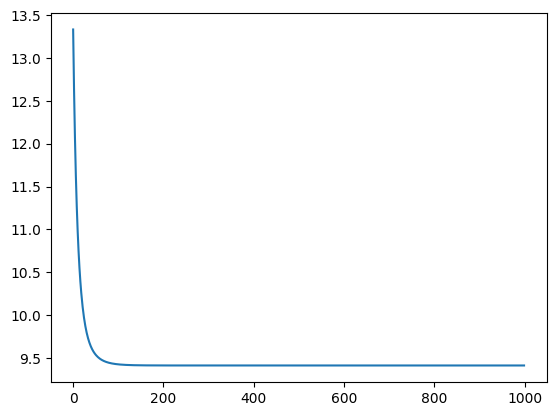

In [ ]:
plt.plot(history)

Now, we calculate accuracy

In [ ]:
def accuracy_ftn(qhat, t):
  yhat = torch.argmax(qhat, axis=1).to(torch.float32)
  y = torch.argmax(t, axis=1).to(torch.float32)
  accuracy = torch.mean((y.reshape([-1])==yhat).to(torch.float32))
  return accuracy


In [ ]:
Zhat = reg_ftn(XX)
Qhat = torch.softmax(Zhat, dim=1)
accuracy = accuracy_ftn(Qhat, T)
accuracy

tensor(0.7500)

#### Transformation of `Y` of shape `[n,1]` into one-hot encoding `T` of shape `[n,2]`.

## Exercise 1.2.2: Logistic regression with Breast cancer data (Off-line)



FIrst, we load data

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer1 = load_breast_cancer()

In [ ]:
print("Predictors: ", cancer1.feature_names)

Predictors:  ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [ ]:
print("\nResponse: ", cancer1.target_names)


Response:  ['malignant' 'benign']


Here we can see that there are 30 predictors available in our dataset that can be used in our logistic regression models.

Purely for convenience, we convert this sklearn.utils.Bunch object to a pandas.DataFrame as pandas DataFrames are a very commonly used data structure. We then use the shape property to see it has 569 rows and 30 columns.

In [ ]:
import pandas as pd

cancer = pd.DataFrame(cancer1.data, columns=cancer1.feature_names)
cancer.columns = cancer.columns.str.replace(' ','_')
cancer.shape

(569, 30)

In [ ]:
cancer1.target[:50] # 1 means malignant.

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1])

In [ ]:

X = torch.tensor(cancer.values, dtype=torch.float32)
n=X.shape[0]


X_mean = torch.mean(X, axis=0)
X_std = torch.std(X, axis=0)
XX = (X-X_mean)/X_std

Y = torch.tensor(cancer1.target, dtype=torch.int64)
T = torch.nn.functional.one_hot(Y, num_classes=2)
T = T.to(torch.float32)

dataset = TensorDataset(XX,T)
trainloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

With the given `trainloader`, train two logistic models and calculate the train accuracies.

In [ ]:
XX.shape

torch.Size([569, 30])

In [ ]:
class softmax(torch.nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.linear = torch.nn.Linear( in_units, units, bias=True)

    def forward(self, X):
        Z = self.linear(X)
        temp = torch.exp(Z)
        Q = temp / torch.sum(temp, axis=1).reshape(-1, 1)
        # P_sum = torch.sum(P, axis=1).reshape(-1, 1)
        # torch.exp( self.linear(X) )
        # P_sum = torch.sum(P, axis=1).reshape(-1, 1)
        # temp = P/P_sum
        return Q

softmax_ftn = softmax(30,2) # Important

def likelihood_function(tt, qq):
  # tt: one-hot encoding of y, shape: [n,2]
  # phat: probability of shape: [n,2]
  temp = -torch.mean (tt * torch.log(qq))
  return temp

optimizer = torch.optim.SGD(softmax_ftn.parameters(), lr= 0.001)

In [ ]:
XX.shape

torch.Size([569, 30])

In [ ]:
history=[]
epochs = 200
n=len(XX)
for i in range(epochs):
  epoch_loss = 0.0
  for xx, tt in trainloader:
    phat = softmax_ftn(xx)
    loss = likelihood_function(tt, phat)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    eopch_loss = epoch_loss + loss.item()*len(tt)
  history.append(eopch_loss)

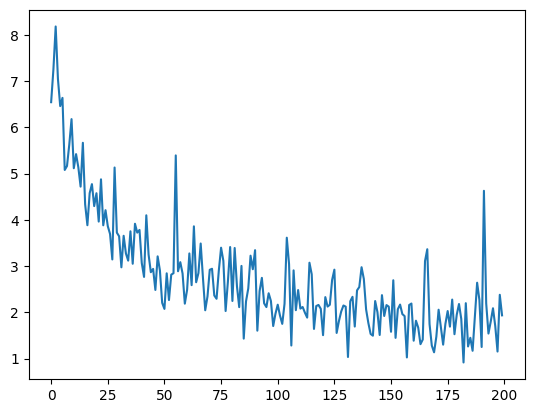

In [ ]:
plt.plot(history)

Now, check the accuracy again.

Now, check the accuracy of the model using `phat=model(XX)` of shape `[n,2]`and `Y` of shape `[n,1]`.

In [ ]:
def accuracy_ftn(phat, t):
  yhat = torch.argmax(phat, axis=1).to(torch.float32)
  y = torch.argmax(t, axis=1).to(torch.float32)
  accuracy = torch.mean((y.reshape([-1])==yhat).to(torch.float32))
  return accuracy


In [ ]:
That = softmax_ftn(XX)
accuracy = accuracy_ftn(That, T)
accuracy

tensor(0.9684)

# 2. Multinomial logistic regression

## 2.1 Definition of some torch functions

### Softmax function

$f$: softmax function

$
f(x_1, x_2, \cdots, x_k) = \frac{\left[\exp(x_1), \cdots, \exp(x_1)\right]}{\sum\limits_{j=1}^{k}\exp(x_j)}
$

In [ ]:
import torch
z2 = torch.tensor([[-1.3, 1.2, 0.3],
                   [1.0, 0.1, -0.5]])
f2  = torch.softmax(z2, dim=0)
f2

tensor([[0.0911, 0.7503, 0.6900],
        [0.9089, 0.2497, 0.3100]])

In [ ]:
z2 = torch.tensor([[-1.3, 1.2, 0.3],
                   [1.0, 0.1, -0.5]]) #[2,3]
q2 = torch.exp(z2) #[2,3]
q2

tensor([[0.2725, 3.3201, 1.3499],
        [2.7183, 1.1052, 0.6065]])

In [ ]:
sum2 = torch.sum(q2, axis=1).reshape([-1, 1]) #[2, 1]
sum2


tensor([[4.9425],
        [4.4300]])

In [ ]:
q2 / sum2

tensor([[0.0551, 0.6717, 0.2731],
        [0.6136, 0.2495, 0.1369]])

In [ ]:
sum2 = np.sum(q2, axis=1).reshape([2,1])  #[2,]
sum2 #[2,]  --> [2,1]

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=int, ), but expected one of:
 * (*, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None)
 * (tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None)


In [ ]:
temp2/sum2

array([[0.05514039, 0.67174747, 0.27311214],
       [0.61360993, 0.24947518, 0.13691488]])

In [ ]:
import torch
z1 = torch.tensor([[-1.3, 1.2, 0.3]])
f1  = torch.softmax(z1, dim=1)

z2 = torch.tensor([[-1.3, 1.2, 0.3],
                   [1.0, 0.1, -0.5]])
f2  = torch.softmax(z2, dim=1)

print(f1)
print(f2)

tensor([[0.0551, 0.6717, 0.2731]])
tensor([[0.0551, 0.6717, 0.2731],
        [0.6136, 0.2495, 0.1369]])


Cross-entropy function

`T`: one-hot encoding of `Y`, shape: `[n, k]`
`z_hat`: probabilities of each class,  shape: '[n,k]'

```
Cross-entropy(z_hat, T)= - torch.mean(sum(T * log(z_hat), axis=1))
```

In [ ]:
t = torch.tensor([[0.3, -0.3, 0.4]])
temp = torch.exp(t)
z = temp/torch.sum(temp)

-torch.sum(t*torch.log(z))

tensor(0.1704)

In [ ]:
t = torch.tensor([[0.3, -0.3, 0.4]])
z= torch.softmax(t, axis=1)
-torch.sum(t*torch.log(z))

tensor(0.1704)

In [ ]:
-torch.sum(t*torch.log(z))

tensor(0.1704)

In [ ]:
t = torch.tensor([0.0, 0, 1])
q = torch.tensor([0.3, 0.3, 0.4])
loss = torch.nn.CrossEntropyLoss(reduction='mean')
output = loss(q, t)


print(output, -1*np.log( np.exp(0.4)/ (np.exp(0.3)+np.exp(0.3)+np.exp(0.4)) ))

tensor(1.0331) 1.0330687599495758


Note that it is also possible to have index instead of `t` as input.

In [ ]:
loss(q, torch.tensor(2))

tensor(1.0331)

In [ ]:

loss = torch.nn.CrossEntropyLoss(reduction='mean')

t = torch.tensor([[0.0,   0,   1],
                  [0,     1,   0]])
z = torch.tensor([[0.3, -0.3, 0.4],
                  [0.5, 0.2, 0.3]])

output = loss(z, t)
output


tensor(1.0579)

In [ ]:
q = torch.softmax(z, axis=1) #[2,3]
q

tensor([[0.3768, 0.2068, 0.4164],
        [0.3907, 0.2894, 0.3199]])

In [ ]:
temp = t * torch.log(q)

In [ ]:
temp

tensor([[-0.0000, -0.0000, -0.8761],
        [-0.0000, -1.2398, -0.0000]])

In [ ]:
torch.mean(-torch.sum(temp, axis=1))

tensor(1.0579)

In [ ]:
torch.sum(t * torch.log(q), axis=1)

tensor([-0.8761, -1.2398])

In [ ]:
t = torch.tensor([[0.0, 0, 1],
                 [0, 1, 0]])
q = torch.tensor([[0.3, 0.3, 0.4],
                  [0.5, 0.2, 0.3]])
loss = torch.nn.CrossEntropyLoss(reduction='mean')
output = loss(q, t)

print(-1*np.log( np.exp(0.4)/ (np.exp(0.3)+np.exp(0.3)+np.exp(0.4)) ),
      -1*np.log( np.exp(0.2)/ (np.exp(0.5)+np.exp(0.2)+np.exp(0.3)) ))
print(output)

1.0330687599495758 1.23983106084446
tensor(1.1364)


In [ ]:
(1.033+1.239)/2

1.1360000000000001

In [ ]:
q

tensor([[0.3000, 0.3000, 0.4000],
        [0.5000, 0.2000, 0.3000]])

Now, we use label instead of one-hot encoding.

In [ ]:
loss(q, torch.tensor([2,1]))

tensor(1.1364)

## 2.2 Load MNIST data

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd

In [ ]:


mnist = sklearn.datasets.fetch_openml('mnist_784', data_home="mnist_784")




In [ ]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [ ]:
np.array(mnist["target"].values).astype(np.float64)

array([5., 0., 4., ..., 4., 5., 6.])

In [ ]:
X = torch.tensor(mnist["data"].values, dtype=torch.float32).reshape([-1, 28* 28])
Y = torch.tensor(np.array(mnist["target"].values).astype(np.float64), dtype=torch.float32)
print(X.shape, Y.shape)

T = torch.nn.functional.one_hot(torch.tensor(Y, dtype=torch.int64), num_classes=10)
T = torch.tensor(T, dtype=torch.float32)


torch.Size([70000, 784]) torch.Size([70000])


<ipython-input-67-b1f08db0a04a>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.nn.functional.one_hot(torch.tensor(Y, dtype=torch.int64), num_classes=10)
<ipython-input-67-b1f08db0a04a>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T, dtype=torch.float32)


In [ ]:
X.shape

torch.Size([70000, 784])

In [ ]:
Y.shape

torch.Size([70000])

In [ ]:
Y[:10]

tensor([5., 0., 4., 1., 9., 2., 1., 3., 1., 4.])

In [ ]:
T[:10]

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

tensor(5.)


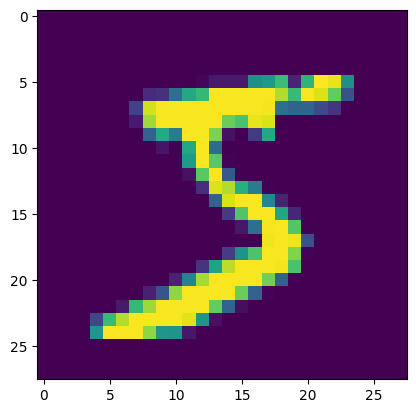

In [ ]:
plt.imshow(X[0].reshape(28,28))
print(Y[0])

"그림: [28.28] matrix  =  길이가 [784]인 Vector =784개의 설명변수

In [ ]:
X[0]

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   

In [ ]:
x_train = torch.tensor(X[:60000, :]/255, dtype = torch.float32)
y_train = torch.tensor(Y[:60000], dtype = torch.float32)
t_train = torch.tensor(T[:60000], dtype = torch.float32)
n=60000
x_test = torch.tensor(X[60000:, :]/255, dtype = torch.float32)
y_test = torch.tensor(Y[60000:], dtype = torch.float32)
t_test = torch.tensor(T[60000:], dtype = torch.float32)

<ipython-input-74-fd234ed319a3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(X[:60000, :]/255, dtype = torch.float32)
<ipython-input-74-fd234ed319a3>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(Y[:60000], dtype = torch.float32)
<ipython-input-74-fd234ed319a3>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_train = torch.tensor(T[:60000], dtype = torch.float32)
<ipython-input-74-fd234ed319a3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clon

In [ ]:
X.shape

torch.Size([70000, 784])

In [ ]:
traindata = TensorDataset(x_train, t_train)
trainloader=DataLoader(dataset = traindata, batch_size=32, shuffle=True)
testdata = TensorDataset(x_test, t_test)
testloader=DataLoader(dataset = testdata, batch_size=32, shuffle=True)

## 2.3 Multinomial logistic regression for MNIST data

## Example 2.3.1 MNIST data and multinomial logistic regression

Train MNIST using basic torch function.

In [ ]:
z_model = nn.Linear(784, 10, bias=True)

def loss_fn(qhat, t):
  loss = - torch.mean(torch.sum(t * torch.log(qhat), axis=1))
  return loss

optimizer = torch.optim.SGD(z_model.parameters(), lr=0.01)
history=[]
epochs = 30

for epoch in range(epochs):
  epoch_loss = 0.0
  for xx, tt in trainloader:
    zhat = z_model(xx)
    qhat = torch.softmax(zhat, dim=1)
    loss = loss_fn(qhat, tt)
    loss.backward()
    epoch_loss += loss.item()*len(xx)
    optimizer.step()
    optimizer.zero_grad()
  history.append(epoch_loss/n)
plt.plot(history)

KeyboardInterrupt: 

Now, check the accuracy of the model using `phat=model(XX)` of shape `[n,2]`and `Y` of shape `[n,1]`.

In [ ]:
def accuracy_ftn(qhat, t):
  yhat = torch.argmax(qhat, axis=1).to(torch.float32)
  y = torch.argmax(t, axis=1).to(torch.float32)
  accuracy = torch.mean((y==yhat).to(torch.float32))
  return accuracy


In [ ]:
zhat = z_model(x_test)
qhat = torch.softmax(zhat, dim=1)
accuracy = accuracy_ftn(qhat, t_test)
accuracy

tensor(0.9218)

## Example 2.3.2 MNIST data and multinomial logistic regression

Repeat the above training process using `nn.CrossEntropyLoss()` function.

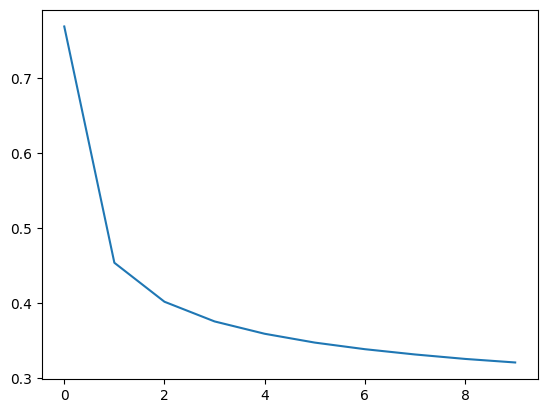

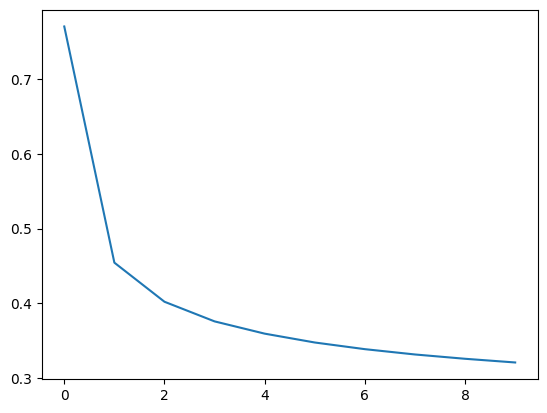

In [ ]:
z_model = nn.Linear(784, 10, bias=True) #X:[n, 784] #name changed

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')# This is the only change

optimizer = torch.optim.SGD(z_model.parameters(), lr=0.01)
history=[]
epochs = 10

for epoch in range(epochs):
  epoch_loss = 0.0
  for xx, tt in trainloader:
    zhat = z_model(xx)
    loss = loss_fn(zhat, tt)
    loss.backward()
    epoch_loss += loss.item()*len(xx)
    optimizer.step()
    optimizer.zero_grad()
  history.append(epoch_loss/n)
plt.plot(history)

In [ ]:
zhat_test = z_model(x_test)
Q_test = torch.softmax(zhat_test, axis=1)
#y_test
y_hat = torch.argmax(Q_test, axis=1).to(torch.float32)

torch.mean((y_hat ==y_test.reshape([-1])).to(torch.float32))


tensor(0.9160)

Now, check the accuracy of the model using `phat=model(XX)` of shape `[n,2]`and `Y` of shape `[n,1]`.

In [ ]:
def accuracy_ftn(phat, t):
  yhat = torch.argmax(phat, axis=1).to(torch.float32)
  y = torch.argmax(t, axis=1).to(torch.float32)
  accuracy = torch.mean((y.reshape([-1])==yhat).to(torch.float32))
  return accuracy


In [ ]:
phat = torch.softmax(z_model(x_test), axis=1)
accuracy = accuracy_ftn(phat, t_test)
accuracy

tensor(0.9154)

### Exercise 2.3.3. Revisit MNIST data (Online)

Modify `z_model` above using the customized layer which produce the probabilities based on `torch.softmax`. Then, you may want to redefine loss function.

## Exercise 2.3.3. Iris data (Offline)

We will be using the famous Iris dataset, which contains measurements of the sepal length, sepal width, petal length, and petal width for three species of iris flowers (Iris setosa, Iris versicolor, and Iris virginica). The goal is to predict the species of an iris flower based on these measurements.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris = load_iris()

# Convert the data to PyTorch tensors
X = torch.tensor(iris.data, dtype=torch.float32)[:,:2] #iris.data의 첫 두 특성(꽃받침 길이와 너비)만 사용
y = torch.tensor(iris.target, dtype=torch.long)

t = torch.nn.functional.one_hot(torch.tensor(y, dtype=torch.int64), num_classes=3) #원핫인코딩함
t = torch.tensor(t, dtype=torch.float32)


# Normalize the input data
mean = torch.mean(X, dim=0)
std = torch.std(X, dim=0)
X = (X - mean) / std

# Split the dataset into training and validation sets
X_train, X_val, t_train, t_val = train_test_split(X, t, test_size=0.2, random_state=42) #데이터를 80% 학습, 20% 검증으로 나눔

# Create PyTorch Datasets
train_dataset = TensorDataset(X_train, t_train)
val_dataset = TensorDataset(X_val, t_val)

# Define the data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #학습용데이터
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) #테스트용데이터


<ipython-input-156-1472463275d6>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.nn.functional.one_hot(torch.tensor(y, dtype=torch.int64), num_classes=3) #원핫인코딩함
<ipython-input-156-1472463275d6>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


Use multinomial logistic regression model to classiy the iris, and calculate the test error.

## Exercise 2.3.4 Revisiting Iris data (HW)

We use `train_loader` to train the model, and use `test_loader` to calculate the test accuracy. Use the following code to train the model, and calculate the test accuracy. In this case, you need to define your own loss function to calculate cross-entropy function from `q_hat` and `tt`.
```
z_model = nn.Linear(784, 10, bias=True)
```
and
```
for xx, tt in train_loader:
  zhat = z_model(xx)
  q_hat = torch.softmax()
```

In [ ]:
print(X.shape, t.shape)

torch.Size([150, 2]) torch.Size([150, 3])


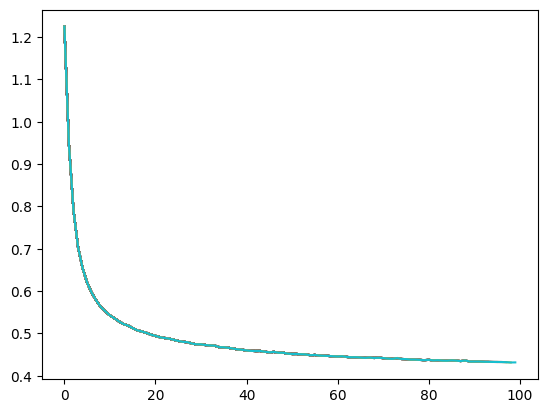

In [ ]:
forward = torch.nn.Linear(2,3,bias=True)

def loss_ftn(t,q):
  return -torch.mean(torch.sum(t*torch.log(q), axis=1))

epochs= 100
optimizer= torch.optim.SGD(forward.parameters(), lr=0.1)
history=[]
n_train = len(train_loader.dataset)

for epoch in range(epochs):
  Loss= 0 # define Loss for each epoch
  for xx, t in train_loader:
    b= forward(xx)
    q= torch.softmax(b, axis=1)
    loss= loss_ftn(t, q)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    Loss += loss.item()*len(xx) # Change LOSS to Loss to accumulate batch losses
  history.append(Loss/n_train)

  plt.plot(history)

In [ ]:
Correct= 0
n_test= len(test_loader.dataset)
for xx,t in test_loader:
  b= forward(xx)
  q= torch.softmax(b, axis=1) #[n,3]
  yhat= torch.argmax(q, axis=1)
  y= torch.argmax(t, axis=1)
  correct= torch.sum((yhat==y)*1.0).item()
  Correct += correct

Correct/ n_test

0.9

In [ ]:
#새로운데이터예측해보기
X[:2,:2]
xx= torch.tensor([[5.0,4.0]], dtype=torch.float32)
xx_std= (xx-mean) / std
xx_std
b= forward(xx_std)
q= torch.softmax(b, axis=1)
q

tensor([[9.9922e-01, 5.8824e-04, 1.9132e-04]], grad_fn=<SoftmaxBackward0>)

## Exercise 2.3.5: Fashion MNIST data (HW)

You are given the following fashion MNIST data. Do the multinomial regression so that the regression machine can determine the label from the images. Calculate the test accuracy. In the test dataset, identify at least 5 cases where your predictions are wrong, and explain why possibly they were mis-classified.

1. the picture

2. predicted label

3. real label

4. Explain the possible reason why your model is wrong in this case.

Hint: Each training and test example is assigned to one of the following labels:

0 T-shirt/top

1 Trouser

2 Pullover

3 Dress

4 Coat

5 Sandal

6 Shirt

7 Sneaker

8 Bag

9 Ankle boot

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
validationset = datasets.FashionMNIST('./data', download=True, train=False, transform=transform)
test_loader = DataLoader(validationset, batch_size=64, shuffle=True)

In [ ]:
xx, yy = trainset[0]

Ankle boot


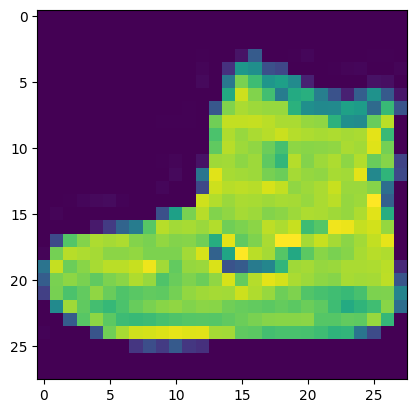

In [ ]:
plt.imshow(xx.reshape(28,28))
my_name = { 0: "T-shirt/top", 1: "Trouser",
              2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}
print(my_name[yy])



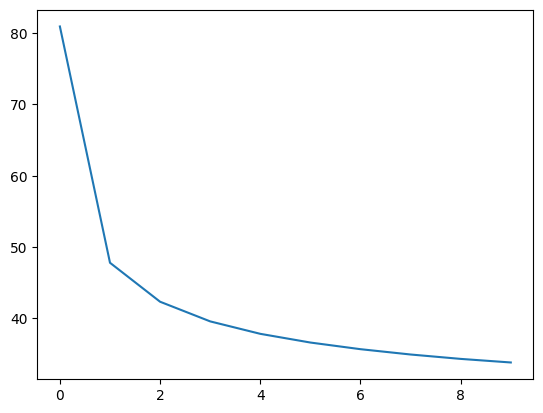

In [ ]:
z_model = nn.Linear(784, 10, bias=True)

loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.SGD(z_model.parameters(), lr=0.01)

history=[]
epochs = 10

for epoch in range(epochs):
  epoch_loss = 0.0
  for xx, tt in trainloader:
    zhat = z_model(xx)
    loss = loss_fn(zhat, tt)
    loss.backward()
    epoch_loss += loss.item()*len(xx)
    optimizer.step()
    optimizer.zero_grad()
  history.append(epoch_loss/n)
plt.plot(history)

In [ ]:
zhat_test = z_model(x_test)
Q_test = torch.softmax(zhat_test, axis=1)
#y_test
y_hat = torch.argmax(Q_test, axis=1).to(torch.float32)

torch.mean((y_hat ==y_test.reshape([-1])).to(torch.float32))

tensor(0.9164)

In [ ]:
class SoftmaxModel(torch.nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()
        self.linear = torch.nn.Linear(input_units, output_units, bias=True)

    def forward(self, X):
        Z = self.linear(X)
        exp_Z = torch.exp(Z)
        Q = exp_Z / torch.sum(exp_Z, axis=1, keepdim=True)  # Normalize over classes
        return Q

softmax_ftn = SoftmaxModel(784, num_classes)



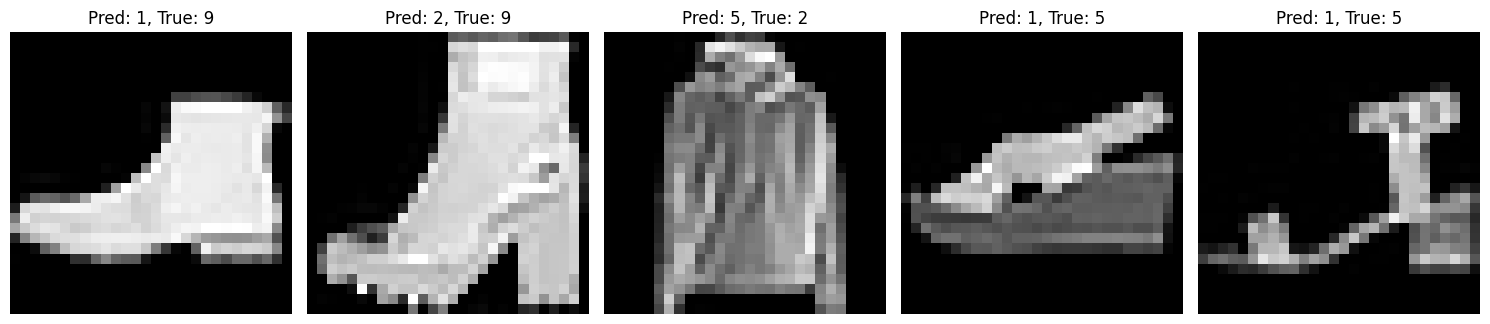

In [ ]:
import matplotlib.pyplot as plt

incorrect_examples = []  # [(image, predicted_label, true_label)]

with torch.no_grad():
    for xx, tt in test_loader:
        xx = xx.view(xx.size(0), 784)  # Reshape to have 784 features
        q = softmax_ftn(xx)  # Predict probabilities
        yhat = torch.argmax(q, axis=1)  # Predicted labels

        for i in range(len(tt)):
            if yhat[i] != tt[i]:  # 잘못된 예측
                incorrect_examples.append((xx[i].view(28, 28), yhat[i].item(), tt[i].item()))

        # 최소 5건의 예시를 저장한 후 루프 종료
        if len(incorrect_examples) >= 5:
            break

# 잘못된 예측 시각화
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (image, pred_label, true_label) in enumerate(incorrect_examples[:5]):
    axes[i].imshow(image.cpu(), cmap="gray")
    axes[i].set_title(f"Pred: {pred_label}, True: {true_label}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

1) 앵클부츠를 바지로 예상:
2) 앵클부츠을 풀오버로 예상
3) 풀오버를 샌들로 예상
4) 샌들을 바지로 예상
5) 샌들을 바지로 예상

모델을 개선하거나 학습을 더 많이 시키자